# Intro to Easy Ocean

Argovis indexes a representation of [Easy Ocean](https://cchdo.ucsd.edu/products/goship-easyocean) data. In this notebook, we tour basic search options for this dataset. Note that we assume you are already familiar with the basic patterns of Argovis' API; if not, try starting with the [Intro to Argovis](https://github.com/argovis/demo_notebooks/blob/main/Intro_to_Argovis.ipynb) notebook first.

## Setup

In addition to importing a few python packages and declaring a couple of helper functions, make sure to plug in your Argovis API key for `API_KEY` at the bottom of the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [11]:
from argovisHelpers import helpers as avh
import datetime, pandas, matplotlib, scipy, numpy, xarray
import matplotlib.pyplot as plt
import helpers

API_ROOT='https://argovis-api.colorado.edu/'
API_KEY=''

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 9)

## Finding and plotting WOCE lines and sections

In order to browse the Easy Ocean WOCE lines, we provide a vocabulary route that summarizes categorical search filters as usual. First check `enum` to see what filters are available, then let's explore one of them:

In [12]:
vocab_params = {
    "parameter": "enum"
}

avh.query('easyocean/vocabulary', options=vocab_params, apikey=API_KEY, apiroot=API_ROOT)

['woceline', 'data', 'metadata']

In [13]:
vocab_params = {
    "parameter": "woceline"
}

wocelines = avh.query('easyocean/vocabulary', options=vocab_params, apikey=API_KEY, apiroot=API_ROOT)
wocelines

['75N',
 'A02',
 'A03',
 'A05',
 'A10',
 'A12',
 'A13',
 'A16-A23',
 'A20',
 'A22',
 'A9.5',
 'AR07E',
 'AR07W',
 'I01',
 'I02',
 'I03-I04',
 'I05',
 'I06S',
 'I07',
 'I08N',
 'I08S-I09N',
 'I09S',
 'I10',
 'IR06-I10',
 'IR06E',
 'IR06',
 'P01',
 'P02',
 'P03',
 'P04',
 'P06',
 'P09',
 'P10',
 'P11',
 'P13',
 'P14',
 'P15',
 'P16',
 'P17E',
 'P17',
 'P18',
 'P21',
 'S04I',
 'S04P',
 'SR01',
 'SR03',
 'SR04']

Perhaps we're interested in A10. We can see all the times the A10 line has been populated in the A10 metadata; Easy Ocean metadata documents corespond to WOCE lines, and have `id` that matches the WOCE line identifier: 

In [14]:
easyocean_meta_params = {
    "woceline": "A10" # or anything from the list above
}

easyocean_meta = avh.query('easyocean/meta', options=easyocean_meta_params, apikey=API_KEY, apiroot=API_ROOT)
easyocean_meta

[{'_id': 'A10',
  'occupancies': [{'varying_direction': 'lon',
    'static_direction': 'lat',
    'expocodes': ['06MT22_5'],
    'time_boundaries': ['1992-12-30T00:00:00.000Z',
     '1993-01-28T00:00:00.000Z']},
   {'varying_direction': 'lon',
    'static_direction': 'lat',
    'expocodes': ['49NZ200311_4'],
    'time_boundaries': ['2003-11-07T00:00:00.000Z',
     '2003-12-02T00:00:00.000Z']},
   {'varying_direction': 'lon',
    'static_direction': 'lat',
    'expocodes': ['33RO20110926'],
    'time_boundaries': ['2011-09-28T00:00:00.000Z',
     '2011-10-29T00:00:00.000Z']}],
  'date_updated_argovis': '2024-01-16T19:20:58.015Z',
  'data_type': 'easyocean'}]

The `occupancies` key in the A10 metadata indicates that Easy Ocean has 3 traversals of A10; one at the end of 1992, one in late 2003, and one in the autumn of 2011. Perhaps we're interested in the 2003 data; we can request it as follows, by filtering on WOCE line as well as `section_start_date`, which should match the first element in the `time_boundaries` key of the metadata entry of interest:

In [16]:
easyocean_data_params = {
    "woceline": 'A10',
    "section_start_date": '2003-11-07T00:00:00.000Z',
    "data": 'all'
}

easyocean_data_2003 = avh.query('easyocean', options=easyocean_data_params, apikey=API_KEY, apiroot=API_ROOT, verbose=True)

https://argovis-api.colorado.edu/easyocean?woceline=A10&section_start_date=2003-11-07T00:00:00.000Z&data=all


As with all Argovis indexed data, records come back sorted by 'timestamp'. However, Easy Ocean only reports timestamp to the nearest day; in order to put data records in a meaningful order, we should sort them by the 'varying_direction' from the metadata, longitude in A10's case:

In [17]:
def sort_dictionaries_by_geolocation(dictionaries, sort_by):
    for dictionary in dictionaries:
        geolocation = dictionary['geolocation']
        if sort_by == 'longitude':
            dictionary['longitude'] = geolocation['coordinates'][0]
        elif sort_by == 'latitude':
            dictionary['latitude'] = geolocation['coordinates'][1]

    sorted_dictionaries = sorted(dictionaries, key=lambda x: x[sort_by])
    return sorted_dictionaries

easyocean_data_2003 = sort_dictionaries_by_geolocation(easyocean_data_2003, 'longitude')

Let's map this data just to make sure it looks like A10:

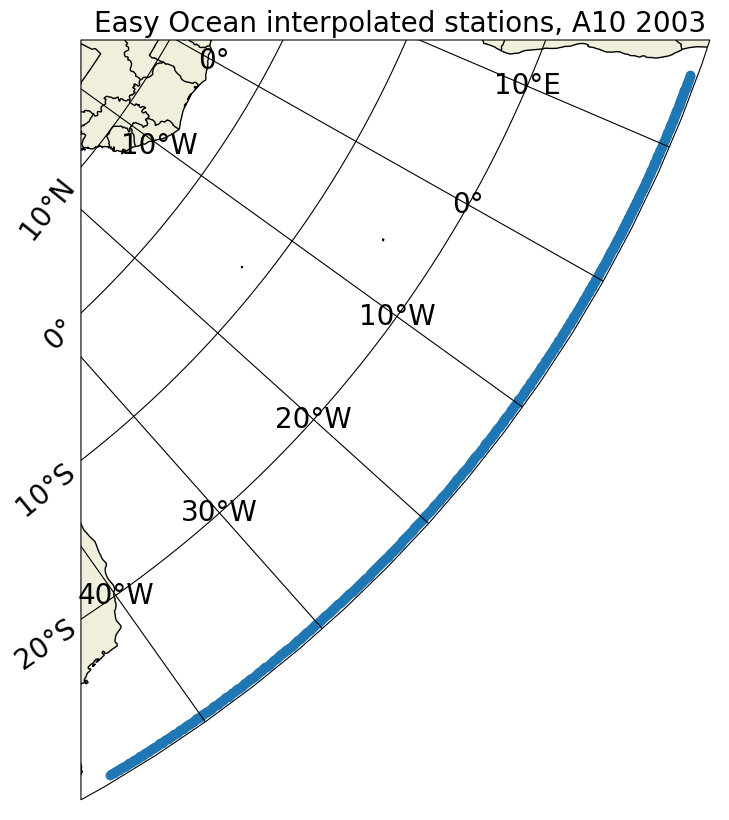

In [18]:
eo_longitudes = [x['geolocation']['coordinates'][0] for x in easyocean_data_2003]
eo_latitudes  = [x['geolocation']['coordinates'][1] for x in easyocean_data_2003]

helpers.simple_map(eo_longitudes, eo_latitudes, title='Easy Ocean interpolated stations, A10 2003')

We may also want to compare interpolated stations and levels across time. Let's first download the 1992 traversal of A10 exactly as we did above: 

In [19]:
easyocean_data_params = {
    "woceline": 'A10',
    "section_start_date": '1992-12-30T00:00:00.000Z',
    "data": 'all'
}

easyocean_data_1992 = avh.query('easyocean', options=easyocean_data_params, apikey=API_KEY, apiroot=API_ROOT)
easyocean_data_1992 = sort_dictionaries_by_geolocation(easyocean_data_1992, 'longitude')

Let's find two comparable points between these two datasets; Easy Ocean interpolates to standard locations, so we can match by latitude and longitude:

In [20]:
idx_1992 = 300 # let's compare the profiles at whatever location is at this index in the 1992 data; feel free to change this index to any other in range.
idx_2003 = None
def find_matching_station(geolocation, occupancy):
    for i in range(len(occupancy)):
        if occupancy[i]['geolocation'] == geolocation:
            return i
        
    return -1

idx_2003 = find_matching_station(easyocean_data_1992[idx_1992]['geolocation'], easyocean_data_2003)
        
print(easyocean_data_1992[idx_1992]['geolocation'])
print(easyocean_data_2003[idx_2003]['geolocation'])


{'coordinates': [-17.3, -29.57], 'type': 'Point'}
{'coordinates': [-17.3, -29.57], 'type': 'Point'}


So we've found the same interpolated station in 1992 and 2003. Next let's check that these two measurements at this location have comparable levels; again, Easy Ocean interpolates to standard levels, but different traversals of A10 might have measured to different depths:

In [21]:
pressure_index_1992 = easyocean_data_1992[idx_1992]['data_info'][0].index('pressure')
pressure_index_2003 = easyocean_data_2003[idx_2003]['data_info'][0].index('pressure')
print('1992 levels:', easyocean_data_1992[idx_1992]['data'][pressure_index_1992])
print('2003 levels:', easyocean_data_2003[idx_2003]['data'][pressure_index_2003])

1992 levels: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620, 1630, 1640, 1650, 1660, 1670, 1680, 1690, 1700, 1710, 1720, 1730, 1740, 1750, 1760, 1770, 1780, 1790, 1800, 1810, 1820, 18

For most interpolated stations, profiles from one traversal to another may terminate at different depths; we'll just consider the levels common to both years for this simple first example. Let's slice the conservative temperatures for both years to these common levels and plot their difference:

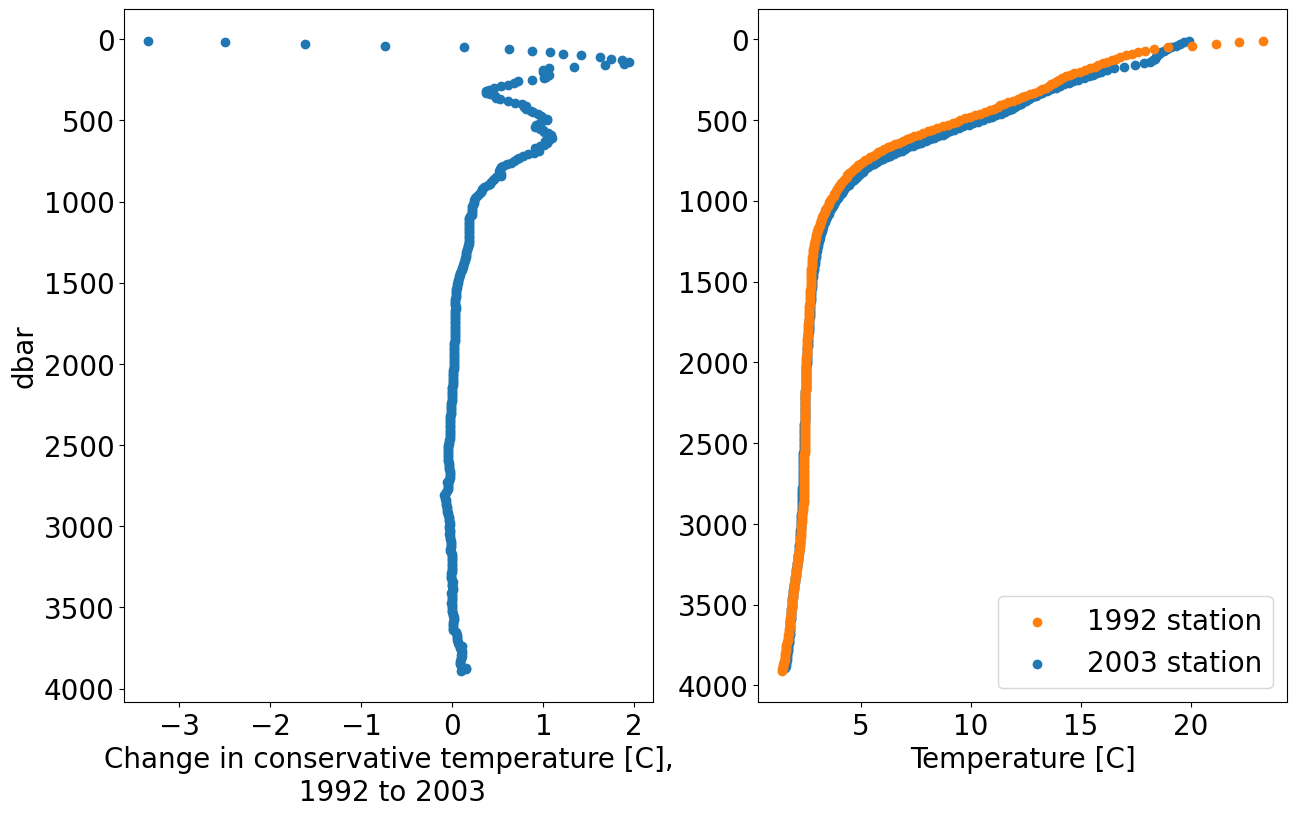

In [22]:
def level_delta(p_late, p_early, var_late, var_early):
    common_elements = []
    difference = []

    for j in range(len(p_late)):
        for k in range(len(p_early)):
            if p_late[j] == p_early[k]:
                common_elements.append(p_late[j])
                difference.append(var_late[j] - var_early[k])

    return difference, common_elements

temp_index_1992 = easyocean_data_1992[idx_1992]['data_info'][0].index('conservative_temperature')
temp_index_2003 = easyocean_data_2003[idx_2003]['data_info'][0].index('conservative_temperature')

temp_delta, levels = level_delta(
    easyocean_data_2003[idx_2003]['data'][pressure_index_2003],
    easyocean_data_1992[idx_1992]['data'][pressure_index_1992],
    easyocean_data_2003[idx_2003]['data'][temp_index_2003],
    easyocean_data_1992[idx_1992]['data'][temp_index_1992]
)

fig, axs = plt.subplots(1, 2)
axs[0].scatter(temp_delta, levels)
axs[0].invert_yaxis()
axs[0].set(xlabel="Change in conservative temperature [C],\n 1992 to 2003", ylabel="dbar")

scat_2003 = axs[1].scatter(easyocean_data_2003[idx_2003]['data'][temp_index_2003], easyocean_data_2003[idx_2003]['data'][pressure_index_2003])
scat_1992 = axs[1].scatter(easyocean_data_1992[idx_1992]['data'][temp_index_1992], easyocean_data_1992[idx_1992]['data'][pressure_index_1992])
axs[1].invert_yaxis()
axs[1].set(xlabel="Temperature [C]")
axs[1].legend((scat_1992, scat_2003), ('1992 station', '2003 station'))



## Plotting full sections

Above we arbitraily chose a specific interpolated station to compare, but we could also compare all the stations in a single plot as follows:

In [23]:
def colormap(matrix, index, xlabel, ylabel, clabel, clabelpad=20, cmap='viridis', coercecolor=False):
    ar = numpy.array(matrix).T
    df = pandas.DataFrame(ar, index=rng)
    if coercecolor:
        global_min = min([x for i in ar for x in i])
        global_max = max([x for i in ar for x in i])
        absrange = max(abs(global_min), abs(global_max))
        plt.pcolor(df, cmap=cmap, vmin=-1*absrange, vmax=absrange)
    else:
        plt.pcolor(df, cmap=cmap)
    tickidx = numpy.arange(0, len(df.index), 100)
    plt.yticks(tickidx, [df.index[x] for x in tickidx])
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.gca().invert_yaxis()
    cbar = plt.colorbar()
    cbar.set_label(clabel, rotation=270,labelpad=clabelpad)
    plt.show()

In [24]:
# identify the profile with the most levels and record the level spectrum - this will set the y range for our plot;
# easyocean has a standard level spectrum, all profiles will be a subset of whichever is longest

rng = []
for p in easyocean_data_2003 + easyocean_data_1992:
    pressure_index = p['data_info'][0].index('pressure')
    if len(p['data'][pressure_index]) > len(rng): 
        rng = p['data'][pressure_index]

In [25]:
# calculate the temperature differences, and pad with NaN to match the level spectrum found above

temperature_change = []

for p_2003 in easyocean_data_2003:
    match_idx = find_matching_station(p_2003['geolocation'], easyocean_data_1992)
    p_1992 = easyocean_data_1992[match_idx]
    
    pressure_index_1992 = p_1992['data_info'][0].index('pressure')
    pressure_index_2003 = p_2003['data_info'][0].index('pressure')
    temp_index_1992 = p_1992['data_info'][0].index('conservative_temperature')
    temp_index_2003 = p_2003['data_info'][0].index('conservative_temperature')
    
    # temperature change for matching interpolated stations and levels:
    temp_delta, levels = level_delta(
        p_2003['data'][pressure_index_2003],
        p_1992['data'][pressure_index_1992],
        p_2003['data'][temp_index_2003],
        p_1992['data'][temp_index_1992]
    )
    
    # pad to match full level spectrum
    t = []
    for lvl in rng:
        if lvl in levels:
            t.append(temp_delta[levels.index(lvl)])
        else:
            t.append(numpy.NAN)
            
    temperature_change.append(t)

In [26]:
# construct temperature matrices for both occupancies so we can also plot the raw temperature profiles:

raw1992 = []
for p in easyocean_data_1992:
    t = []
    temp_index = p['data_info'][0].index('conservative_temperature')
    pres_index = p['data_info'][0].index('pressure')
    for lvl in rng:
        if lvl in p['data'][pres_index]:
            t.append(p['data'][temp_index][p['data'][pres_index].index(lvl)])
        else:
            t.append(numpy.NAN)
    raw1992.append(t)
    
raw2003 = []
for p in easyocean_data_2003:
    t = []
    temp_index = p['data_info'][0].index('conservative_temperature')
    pres_index = p['data_info'][0].index('pressure')
    for lvl in rng:
        if lvl in p['data'][pres_index]:
            t.append(p['data'][temp_index][p['data'][pres_index].index(lvl)])
        else:
            t.append(numpy.NAN)
    raw2003.append(t)

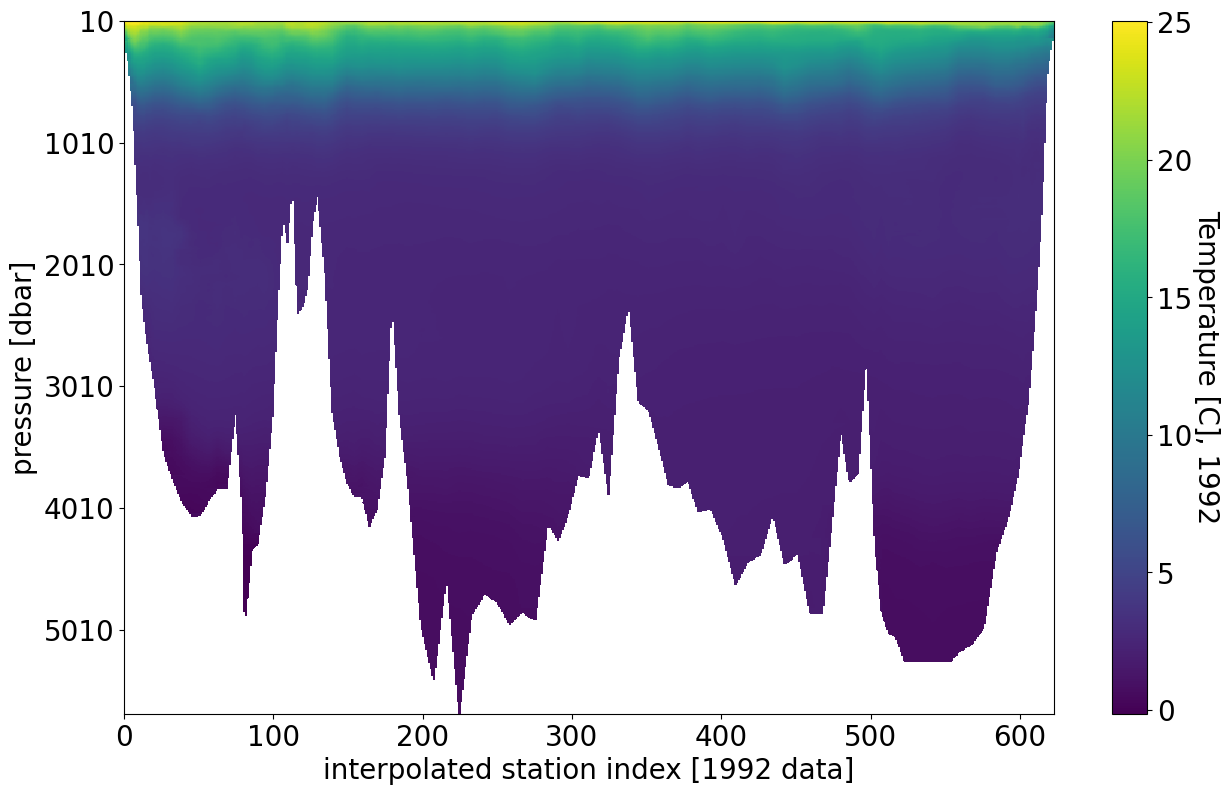

In [27]:
colormap(raw1992, rng, 'interpolated station index [1992 data]', 'pressure [dbar]', 'Temperature [C], 1992')

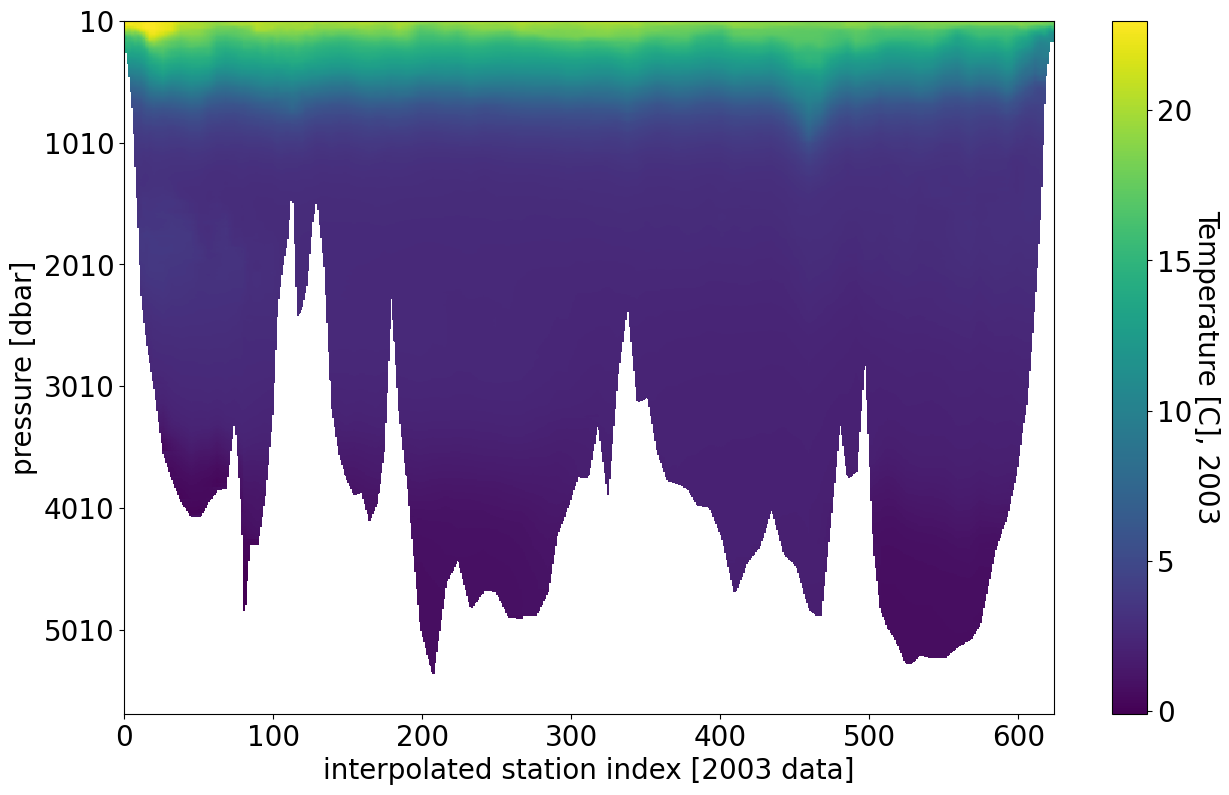

In [28]:
colormap(raw2003, rng, 'interpolated station index [2003 data]', 'pressure [dbar]', 'Temperature [C], 2003')

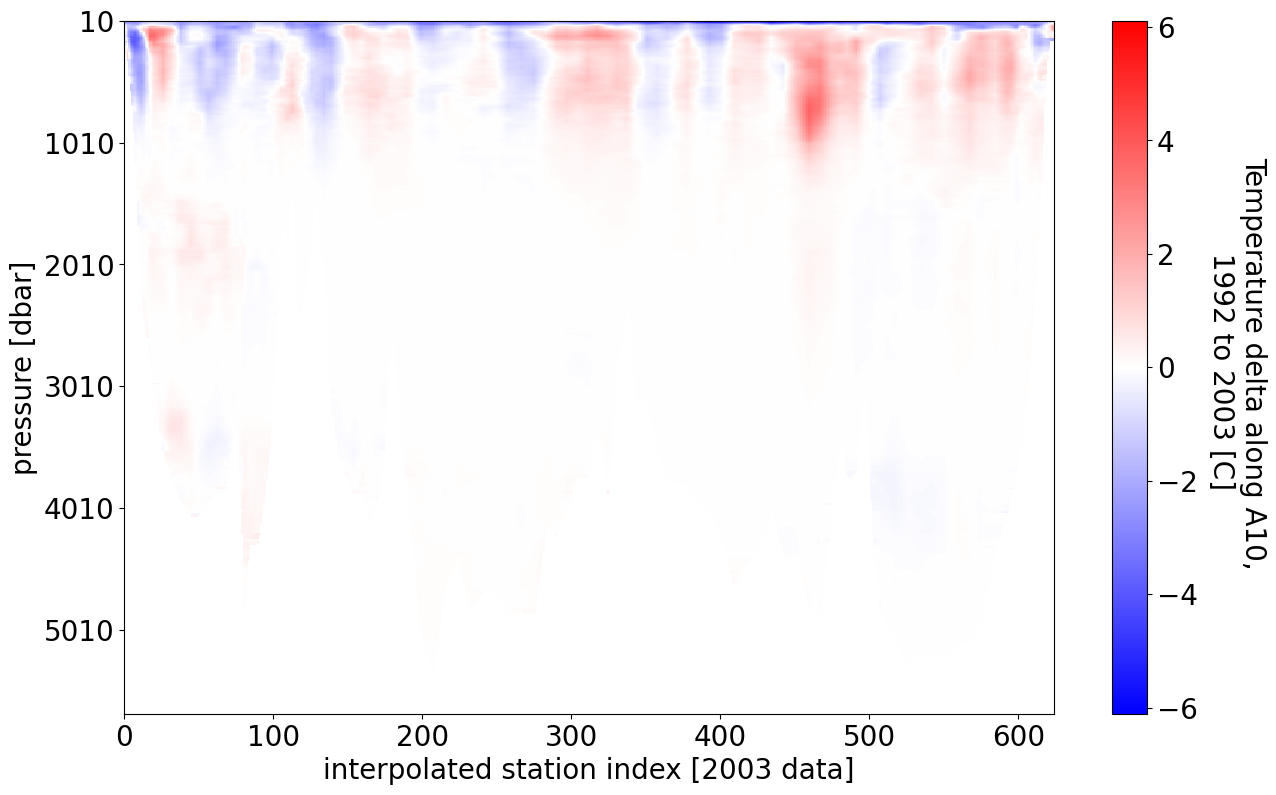

In [29]:
colormap(temperature_change, rng, 'interpolated station index [2003 data]', 'pressure [dbar]', 'Temperature delta along A10, \n 1992 to 2003 [C]', 50, cmap='bwr', coercecolor=True)

## Plots with xarray

`xarray` is a useful tool for manipulating rectangular data like Easy Ocean; let's make an `xarray` dataset out of our A10 data and plot temperatures at an arbitrary level.

In [30]:
# first make an appropriate dataframes, then convert to datasets:

df1992 = helpers.level_df(easyocean_data_1992, ['pressure', 'longitude', 'conservative_temperature'], index=['pressure', 'longitude'])
df2003 = helpers.level_df(easyocean_data_2003, ['pressure', 'longitude', 'conservative_temperature'], index=['pressure', 'longitude'])

ds1992 = df1992.to_xarray()
ds2003 = df2003.to_xarray()

In [31]:
# now we can slice for a pressure of interest:

level = 100
slice1992 = ds1992.sel(pressure=level)
slice2003 = ds2003.sel(pressure=level)

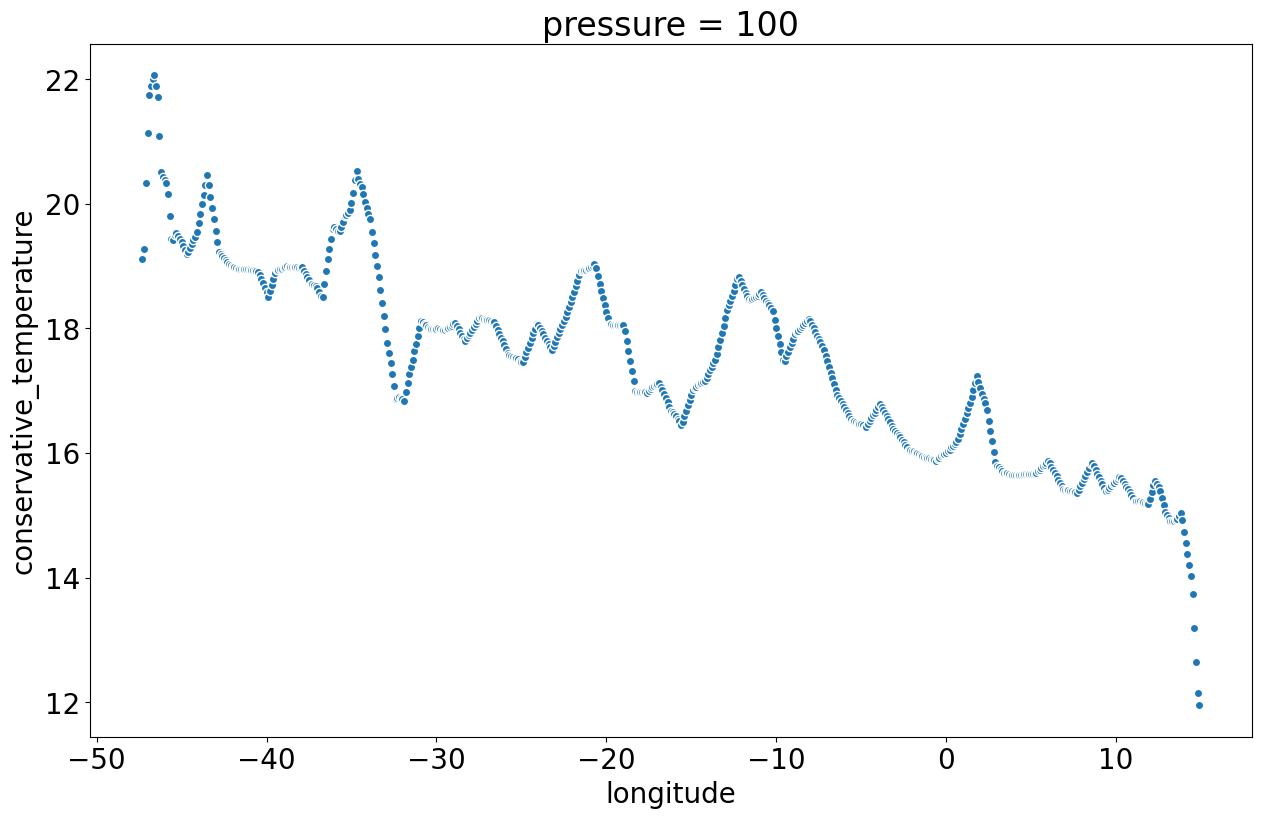

In [32]:
slice1992.plot.scatter(y='conservative_temperature', x='longitude')

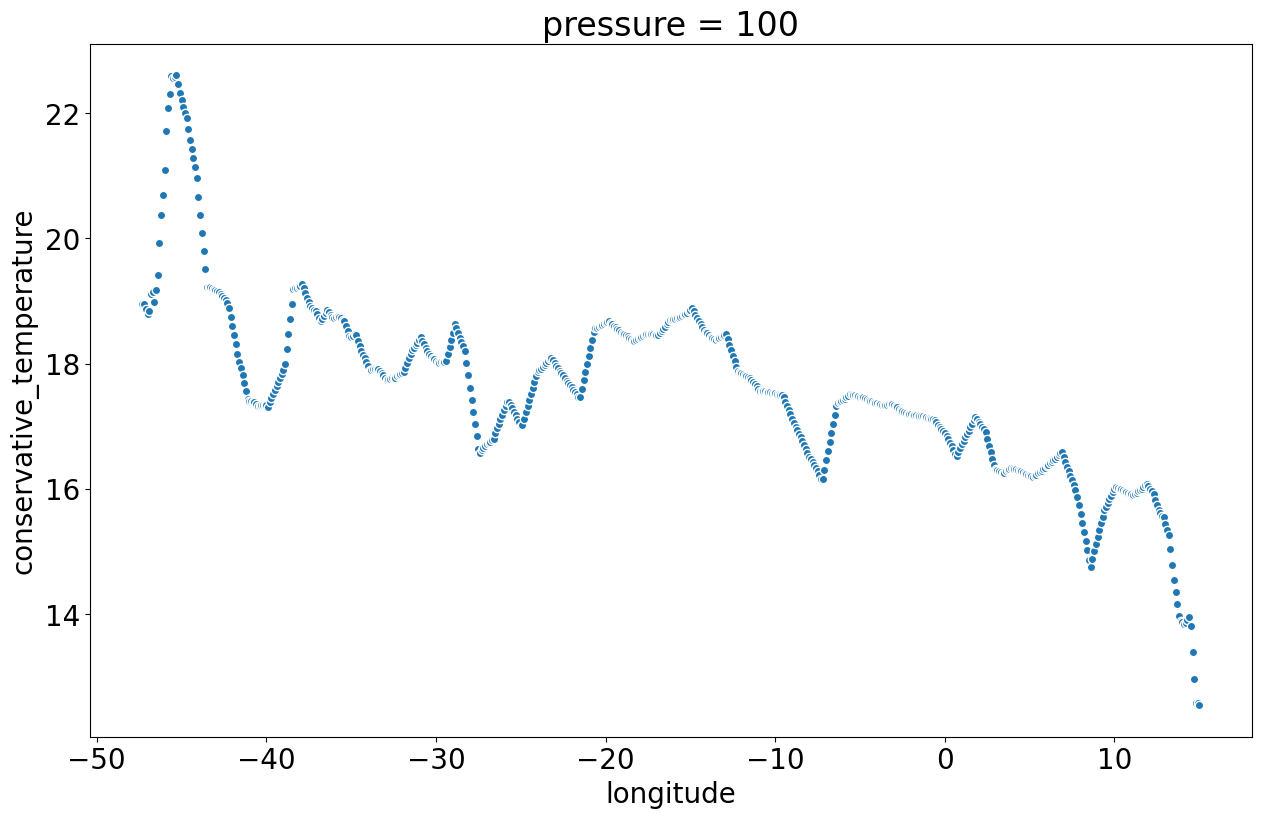

In [33]:
slice2003.plot.scatter(y='conservative_temperature', x='longitude')

Or again, we could visualize all profiles in the section at once:

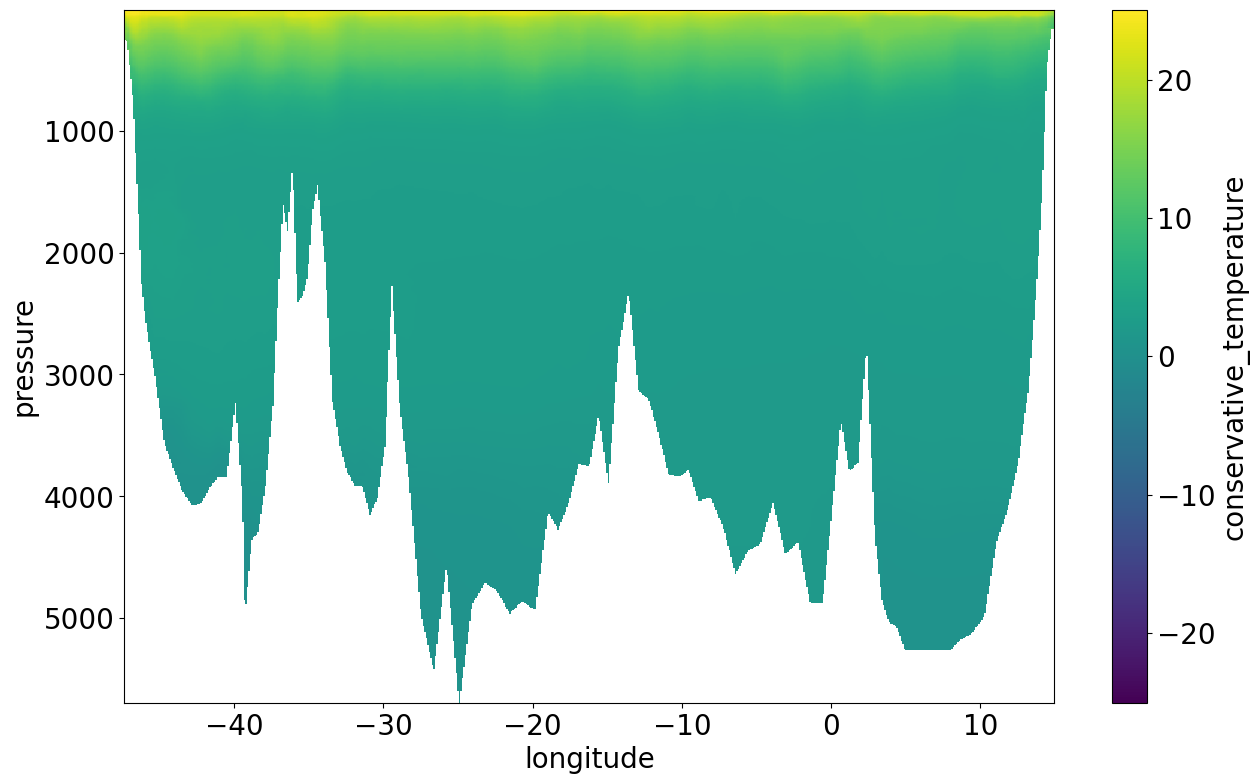

In [34]:
ds1992['conservative_temperature'].plot(yincrease=False, cmap='viridis')

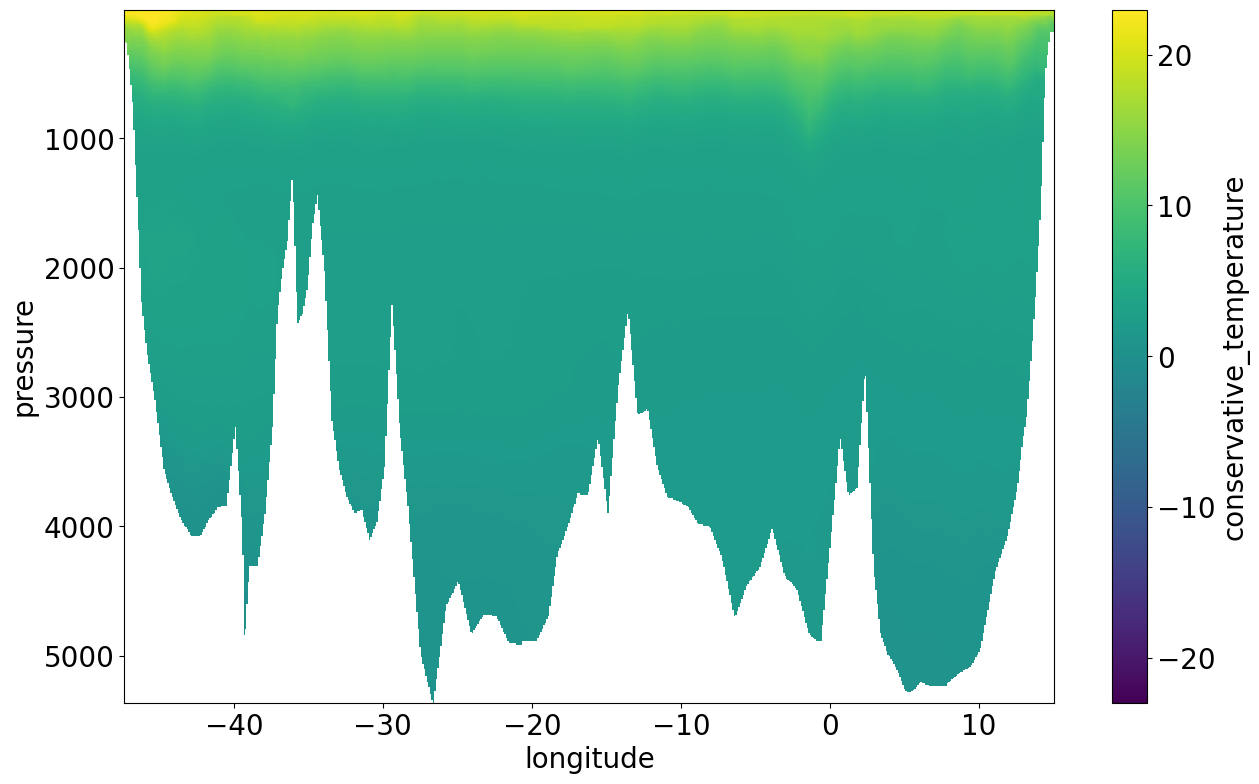

In [35]:
ds2003['conservative_temperature'].plot(yincrease=False, cmap='viridis')

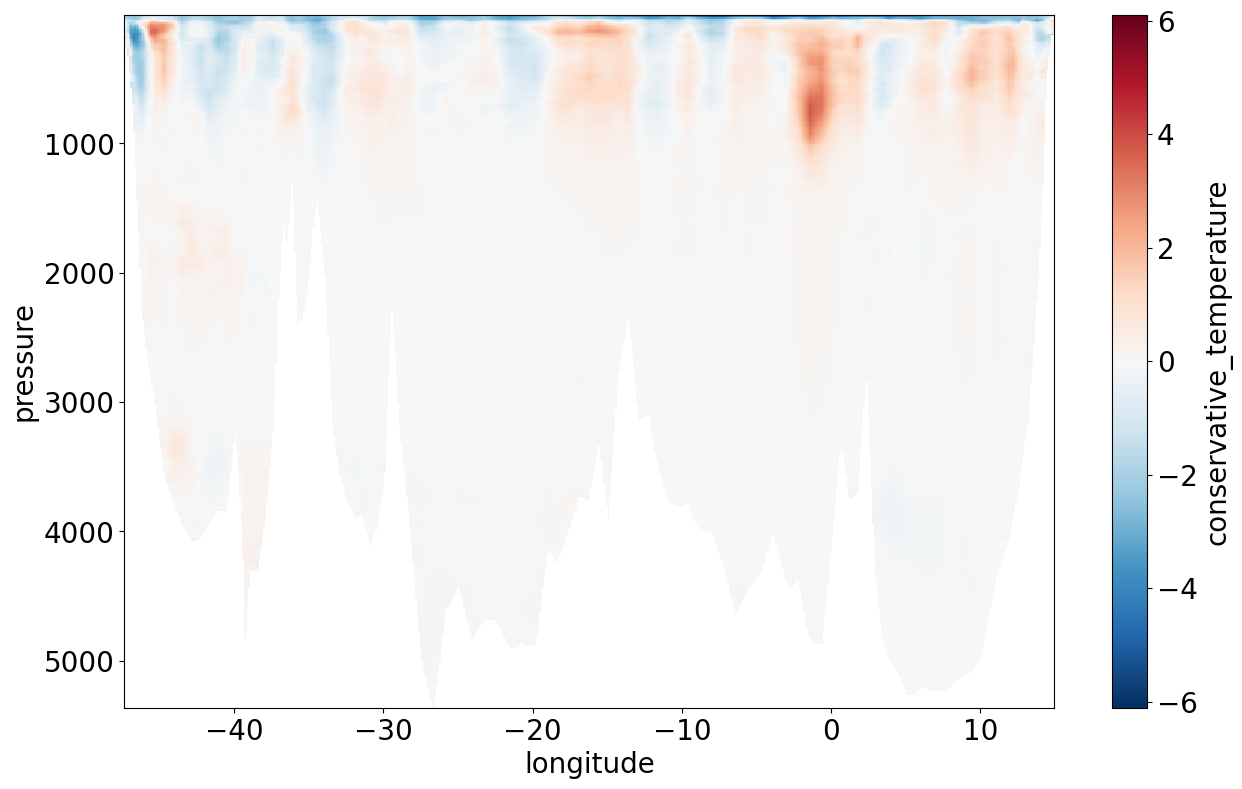

In [36]:
# always align xarrays before trying to take their difference:
align1992, align2003 = xarray.align(ds1992['conservative_temperature'], ds2003['conservative_temperature'])
(align2003-align1992).plot(yincrease=False)